In [349]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Download stock data
We use data from Yahoo finance for the US stock market.

In [2]:
all_stocks = investpy.get_stocks_list(country='United States')
#all_stocks = investpy.etfs.get_etfs_list('united states')
print('There are {} stocks'.format(str(len(all_stocks))))
stocks_selected = all_stocks[:50]
print('out of which '+  str(len(stocks_selected)) + ' are chosen')

There are 4582 stocks
out of which 50 are chosen


In [3]:
#stocks_selected = ' '.join(stocks_selected)
data = yf.download(stocks_selected, start = "2010-01-02", end = "2020-09-05")

[*********************100%***********************]  50 of 50 completed


In the paper, authors drop all assets that contain at least 1 non-traded day (nan). But if we do this here, no stocks would be left at all, so we interpolate missing values

In [4]:
close = data[['Adj Close']].dropna(axis = 1, how = 'all', thresh = data.shape[0] * 0.95) #drop stock if 5% of days are absent
close = close.fillna(0)
close.columns = close.columns.droplevel(0)
close.index = pd.to_datetime(close.index)
close.index = close.index.to_period(freq='d')
print(str(close.shape[1]) + ' stocks left')

44 stocks left


In [5]:
close.head(3)

,AA,ADBE,ADSK,BA,BAC,C,CAKFF,CAT,CSCO,CTAS,...,MRK,MSFT,MSI,ODP,ORCL,PDLI,SHLDQ,T,TEVA,VRTX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,37.018944,37.090000,25.670000,43.441975,13.816905,30.533976,19.843622,42.634403,18.785395,22.366045,...,25.517866,24.168472,26.879293,57.066406,21.604193,3.653801,62.962120,15.742277,47.299187,44.240002
2010-01-05,35.862801,37.700001,25.280001,44.864773,14.266021,31.701447,19.843622,43.144135,18.701702,22.332144,...,25.621284,24.176279,26.508316,59.809143,21.578108,3.648489,65.815117,15.665167,46.629093,42.779999
2010-01-06,37.730419,37.619999,25.340000,46.225727,14.433337,32.689320,19.843622,43.275200,18.579962,22.391468,...,25.966017,24.027906,26.879293,58.482006,21.265123,3.606004,67.075569,15.435946,46.743496,42.029999


In [6]:
returns = close.pct_change().iloc[1:, :]#fill_method='ffill').iloc[1:, :]
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis = 0)
returns = returns.fillna(0)
returns.head(3)

,AA,ADBE,ADSK,BA,BAC,C,CAKFF,CAT,CSCO,CTAS,...,MRK,MSFT,MSI,ODP,ORCL,PDLI,SHLDQ,T,TEVA,VRTX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.031231,0.016446,-0.015193,0.032752,0.032505,0.038235,0.0,0.011956,-0.004455,-0.001516,...,0.004053,0.000323,-0.013802,0.048062,-0.001207,-0.001454,0.045313,-0.004898,-0.014167,-0.033002
2010-01-06,0.052077,-0.002122,0.002373,0.030335,0.011728,0.031162,0.0,0.003038,-0.006510,0.002656,...,0.013455,-0.006137,0.013995,-0.022190,-0.014505,-0.011645,0.019151,-0.014633,0.002453,-0.017532
2010-01-07,-0.021214,-0.019405,0.005525,0.040482,0.032947,0.002747,0.0,0.004038,0.004505,0.008706,...,0.001594,-0.010400,0.020075,0.055976,-0.003271,0.002945,0.116012,-0.011228,-0.006294,-0.012610


### Filter with AR(1)-TGARCH(1,1,1)

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

In [8]:
filt_ret = returns.loc[:'2019-01-01', :]
price_train = close.loc[:'2019-01-01', :]

In [9]:
def filter_train_set(filt_ret, window):
    
    all_ret = np.full((filt_ret.shape[0] - 1, filt_ret.shape[1]), 0, dtype = 'float64')
    for col in range(filt_ret.shape[1]):
        start = 0
        end = start + window
        while end < all_ret.shape[0]-1:
        #mod = HARX(close.iloc[:599], lags = [1, 2], rescale = False)
        #mod.volatility = GARCH(p=1, o=1, q=1)
        #mod.distribution = StudentsT()
            try:
                order = 10 / filt_ret.iloc[start:end, col].std()
            except ZeroDivisionError:
                order = 10
            mod = arch_model(order * filt_ret.iloc[start:end, col],
                            mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                            vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                            dist='skewstudent')#, rescale = False)#    StudentsT') 
            try:
                mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
                all_ret[start:end -1, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
            except: #can be that in this range all values are zero, which throws a mistake
                all_ret[start:end -1, col] = filt_ret.iloc[start:end - 1, col]
            start = end 
            end += window

        end -= 100   
        #print(filt_ret.iloc[end: , col])
        try:
            order = 10 / filt_ret.iloc[end:, col].std()
        except ZeroDivisionError:
            order = 10
        mod = arch_model(order * filt_ret.iloc[end: , col],
                        mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                        vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                        dist='skewstudent')#, rescale = False)#    StudentsT') 
        try:
            mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
            all_ret[end:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
        except: #can be that in this range all values are zero, which throws a mistake
            all_ret[end :, col] = filt_ret.iloc[end: - 1, col]
    filt_ret = pd.DataFrame(all_ret, index = filt_ret.index[1:], columns = filt_ret.columns, dtype = 'float64')
    return filt_ret

In [10]:
filt_ret = filter_train_set(filt_ret, 100)
price_train = filter_train_set(price_train, 100)

C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\mean.py:559: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\mean.py:559: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\mean.py:559: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\mean.py:559: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)


NameError: name 'all_ret' is not defined

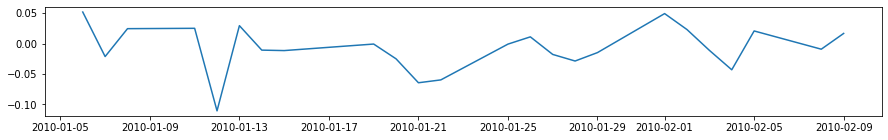

<Figure size 1080x144 with 0 Axes>

In [11]:
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], returns.iloc[1:25, 0], label = 'non-filtered returns');
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], all_ret.iloc[:24, 0], label = 'filtered returns devided by 100');
plt.title('Filtered and non-filtered returns for {}'.format(all_ret.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('percentage returns');

In [ ]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:51], close.iloc[1:51, 0], label = 'non-filtered price');
plt.plot(returns.index.to_timestamp()[1:51], all_res.iloc[:50, 0] + 37, label = 'filtered price + 37');
plt.title('Filtered and non-filtered prices for {}'.format(all_res.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('price');

In [12]:
#split in training, validation and test sets
#THESE ARE FILTERED PRICES
#price_val = all_res.loc['2019-01-01':'2020-01-01']
#price_test = all_res.loc['2020-01-01':]
#THESE ARE NON-FILTERED PRICES
raw_price_train = close.loc[:'2019-01-01', :]
raw_price_val = close.loc['2019-01-01':'2020-01-01']
raw_price_test = close.loc['2020-01-01':]
# returns filtered
#filt_ret = all_ret.loc[:'2019-01-01', :]

### PCA dimensionality reduction and OPTICS clustering
   The authors use 15 principal components in PCA but we use a larger number due to the fact that out time series is longer (authors had 8 years of training data) and it could be we cannot describe it well in 15 components. Then, these components serve as input to OPTICS - density based clustering method. To choose among models, we use silhouette score. It is in range between -1 and 1, the higher it is the better.

In [13]:
def find_max(silhouette):
    all_vals = []
    for val in silhouette.values():
        all_vals.extend(val)
    return all_vals

def best_params(silhouette):
    all_vals = find_max(silhouette)
    max_val = max(all_vals)
    for key, val in silhouette.items():
        if max_val in val:
            return key, val.index(max_val) + 2, max_val

In [14]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

silhouette = dict()
for comp in range(2, 16):
    partial_silh = list()
    pca = PCA(n_components = comp, svd_solver = 'auto')
    pca_fit = pca.fit_transform(filt_ret.transpose())
    for min_sampl in range(2, 7):
        try:
            clusters = OPTICS(min_samples = min_sampl).fit(pca_fit) #metric = 'euclidean' min_cluster_size = 5
            partial_silh.append(silhouette_score(pca_fit, clusters.labels_))
        except: pass
    silhouette[comp] = partial_silh
    
best_comp, best_min_smpl, best_score = best_params(silhouette)
print('best silhouette_score is ' + str(best_score) + ' at ' + str(best_min_smpl) + ' min_samples and ' +
      str(best_comp) + ' components')

best silhouette_score is 0.4288618256424412 at 4 min_samples and 2 components


In [15]:
pca = PCA(n_components = best_comp, svd_solver = 'auto')
pca_fit = pca.fit_transform(filt_ret.transpose())
clusters = OPTICS(min_samples = best_min_smpl).fit(pca_fit)

Number of clusters is 5


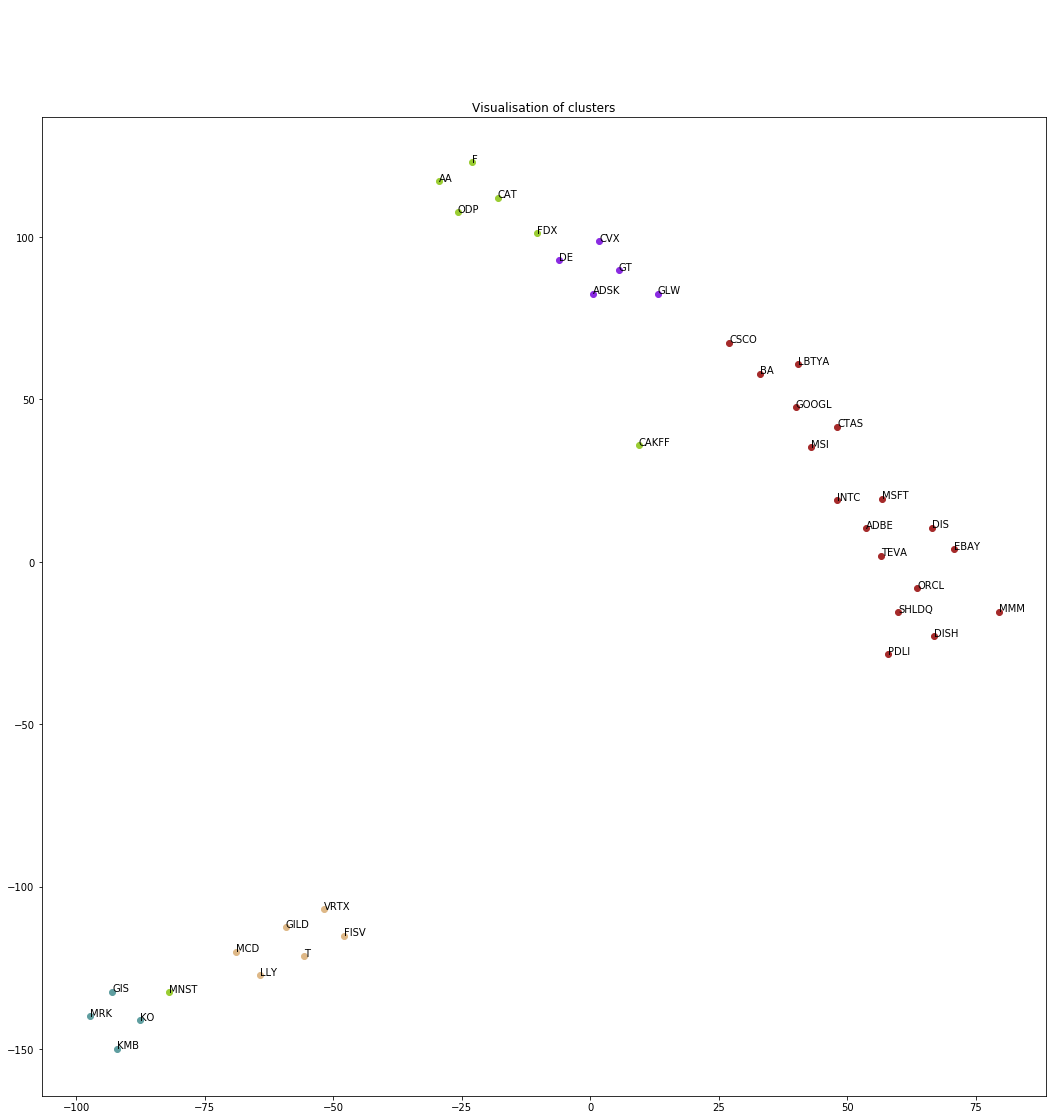

In [16]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components = 2, perplexity = 6).fit_transform(pca_fit)

print('Number of clusters is ' + str(clusters.labels_.max()-clusters.labels_.min()))
colors = list(mcolors.CSS4_COLORS.keys())[10:]
plt.figure(figsize=(18,18))
for klass in range(clusters.labels_.min(), clusters.labels_.max()):
    plt.scatter(tsne[clusters.labels_ == klass][:, 0], tsne[clusters.labels_ == klass][:, 1],
               c = colors[klass], label = 'class {}'.format(str(klass)))
for i, txt in enumerate(filt_ret.columns):
    plt.annotate(txt, (tsne[i, 0], tsne[i, 1]))
#plt.legend()
plt.title('Visualisation of clusters');

In [17]:
#do not include class -1 since these are outliers/points without claster
def make_classes(df):
    classes = dict()
    for cl in range(0, clusters.labels_.max() + 1):
        klass = df.transpose()[clusters.labels_ == cl]
        classes[cl] = klass
    return classes

In [18]:
raw_classes = make_classes(raw_price_train)

### Select pairs
Next, we select pairs based on the following criteria:
- cointegration
- Hurst exponent < 0.5
- half-life of mean reversion
- average number of crossings of spread mean per year

In [19]:
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
from scipy.ndimage.interpolation import shift
from sklearn import linear_model

In [20]:
def compose_pairs(classes):
    pairs = list()
    for cl in classes.keys():
        tested_pairs = list()
        for smpl in range(classes[cl].shape[0]):
            for smpl2 in range(classes[cl].shape[0]):
                if smpl != smpl2 and (smpl2, smpl) not in tested_pairs: #no cointegration with itself, check pair has not been tested
                    tested_pairs.append((smpl2, smpl))
                    cointegrated = coint(classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2, :], return_results = True)
                    if cointegrated[1] < 0.05: #pvalue
                        pairs.append([classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2,:]])
    #pairs = pairs[1:]#the first pair is repeated
    print('There are {} pairs at cointegration stage'.format(len(pairs)))
    return pairs

In [21]:
#check spread mean-reversion
def calc_Hurst(pairs):
    for pair in pairs:
        spread = pair[0] - pair[1]
        H, c, data = compute_Hc(spread)
        if H >= 0.5: #Brownian motion or persistent
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at Hurst stage'.format(len(pairs)))
    return pairs

In [22]:
#check mean-reversion half life
# https://letianzj.github.io/mean-reversion.html

def calc_half_life(pairs):
    lin_reg = linear_model.LinearRegression()
    for pair in pairs:
        for ts_n, ts in enumerate(pair):
            ts_delta = ts - ts.shift()
            lin_reg.fit(np.array(ts.shift()[1:]).reshape(-1,1), np.array(ts_delta[1:]).reshape(-1,1)) 
            half_life = -np.log(2) / lin_reg.coef_.item()
            if half_life < 1 or half_life > 365:
                del pair[ts_n]
                pairs.remove(pair)
                break
    print('There are {} pairs at mean-reversion half life stage'.format(len(pairs)))
    return pairs

In [23]:
#check that on average there are at least 12 crossings of spread mean per year
def number_mean_reversions(pairs):
    years_num  = len(price_train.index.to_timestamp().year.unique())
    for pair in pairs:
        spread = pair[0] - pair[1]
        crosses = 0
        for i in range(len(spread) - 1):
            if (spread[i] > spread.mean() and spread[i + 1] < spread.mean()) or (spread[i] < spread.mean() and spread[i + 1] > spread.mean()):
                crosses += 1
        if crosses < 12 * years_num:
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at calculation of mean-reversions number stage'.format(len(pairs)))
    return pairs

In [24]:
raw_pairs = compose_pairs(raw_classes)
raw_pairs = calc_Hurst(raw_pairs)
raw_pairs = calc_half_life(raw_pairs)
raw_pairs = number_mean_reversions(raw_pairs)

There are 44 pairs at cointegration stage
There are 28 pairs at Hurst stage
There are 19 pairs at mean-reversion half life stage
There are 9 pairs at calculation of mean-reversions number stage


In [25]:
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp()[:50], pairs[0][0][:50], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp()[:50], pairs[0][1][:50], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('filtered price')
plt.title('Filtered prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

NameError: name 'pairs' is not defined

<Figure size 1080x288 with 0 Axes>

In [ ]:
#Попробовать на нефильтрованных данных
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp(), close.loc[pairs[0][0].index, ('Adj Close',pairs[0][0].name)], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp(), close.loc[pairs[0][1].index, ('Adj Close',pairs[0][1].name)], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('price')
plt.title('Prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

### Spread prediction

In [26]:
def spread_change(spread):
    spread_chg = (spread.shift(-1) - spread)[:-1]
    #spread[spread == 0] = 0.00000001 #to avoid division by zero
    spread_chg = spread_chg / spread[:-1]
    return spread_chg

In [27]:
#formation period - train set
#pairs - filtered prices but need to use ordinary ones
spread = pairs[0][0] - pairs[0][1]
spread_chg = spread_change(spread)

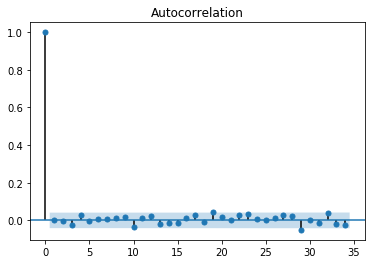

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(spread); #it is rather small, so try lags in range of 1

In [38]:
q = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
d = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

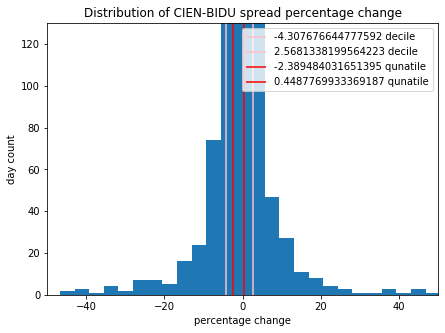

In [31]:
plt.figure(figsize=(7, 5))
plt.hist(spread_chg, bins = 500)
plt.title('Distribution of {}-{} spread percentage change'.format(pairs[0][0].name, pairs[0][1].name))
plt.xlabel('percentage change')
plt.ylabel('day count')
for dec in d:
    plt.vlines(dec, 0, 130, colors = 'pink', label = '{} decile'.format(dec))
for quant in q:
    plt.vlines(quant, 0, 130, colors = 'red', label = '{} qunatile'.format(quant))
plt.legend()
plt.xlim(-50, 50)
plt.ylim(0,130);

In [330]:
def arma_garch(price):
    order = 10 / price.std()
    mod = arch_model(order * price,
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')#, rescale = False)#    StudentsT') 
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
    pred = mod_fit.forecast(horizon=1)
    return mod_fit.resid[1:] / mod_fit.conditional_volatility[1:], float(pred.mean.iloc[-1]), float(pred.variance.iloc[-1])

In [28]:
def trade(a_sh, a_lo, window, account, next_df, previous_df, name1, name2, mode = 'none'):
    """Insert only unfiltered previous_df and next_df, else they will be filtered twice"""
    portfolio_value_list = []
    acc_return_list = []
    cap_invested = []
    comission = 0.001
    stock1 = 0
    stock2 = 0
    acc_return = 0.0
    prev_capital = 0.0
    prev_price1 = 0.0
    prev_price2 = 0.0
    prev_stock1 = 0
    prev_stock2 = 0
    start_idx = 0
    trade_indicator = 'no_trade'
    portfolio_value = 0
    end_idx = start_idx + window + 1 #last observation is not included
    resid = 0.0
    full_df = pd.concat([previous_df.iloc[-window:,:], next_df], axis = 0)
    while end_idx <= full_df.shape[0] - 1:
        p1 = full_df[name1][start_idx:end_idx]
        p2 = full_df[name2][start_idx:end_idx]
        if mode == 'filter':
            p1 = arma_garch(p1)[0]
            p2 = arma_garch(p2)[0]
        spread = p1 - p2
        arma = ARIMA(np.array(spread), order = (1,0,1)).fit()
        pred = arma.forecast(steps=1, exog=None, alpha=0.01)
        pred_chg = (pred - spread[-1:] / spread[-1:])[0]
        
        price1 = p1[-1:][0]
        price2 = p2[-1:][0]
        #if price1 < 0:
        #    price1 = - price1
        #if price2 < 0:
        #    price2 = - price2
        portfolio_value = resid + stock1 * price1 + stock2 * price2 #portfolio revaluation 
        portfolio_value_list.append(portfolio_value)
        
        if price1 != 0 and price2 != 0: #if stock was traded
            if trade_indicator == 'short':
                acc_return += ((prev_price1 - price1)*prev_stock1 + (price2 - prev_price2)*prev_stock2) / prev_capital
            elif trade_indicator == 'long':
                acc_return += (prev_price2 - price2)*prev_stock2 + (price1 - prev_price1)*prev_price1 / prev_capital
            acc_return_list.append(acc_return)
            
            if pred_chg <= a_sh:
                trade_indicator = 'short'
                deal1 = stock1 * price1 * (1 - comission) #sell stock1
                if stock1 != 0:
                    prev_stock1 = stock1
                if deal1 > allocated_capital: 
                    stock1_to_sell = allocated_capital // (price1 * (1 - comission))
                    deal1 = stock1_to_sell * price1 * (1 - comission)
                    stock1 -= stock1_to_sell
                    if stock1_to_sell != 0:
                        prev_stock1 = stock1_to_sell
                else:
                    stock1 = 0
                account += deal1
                stock_2_bought = account // (price2 * (1 + comission))
                deal2 = stock_2_bought * price2 * (1 + comission) #buy stock2
                if deal2 > allocated_capital:
                    stock_2_bought = allocated_capital // (price2 * (1 + comission))
                    deal2 = stock_2_bought * price2 * (1 + comission)
                account -= deal2
                resid = account
                stock2 += stock_2_bought

                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_2_bought != 0:
                    prev_stock2 = stock_2_bought

            elif pred_chg >= a_lo:
                trade_indicator = 'long'
                deal2 = stock2 * price2 * (1 - comission) #sell stock2
                if stock2 != 0:
                    prev_stock2 = stock2
                if deal2 > allocated_capital:
                    stock2_to_sell = allocated_capital // (price2 * (1 - comission))
                    deal2 = stock2_to_sell * price2 * (1 - comission)
                    stock2 -= stock2_to_sell
                    if stock2_to_sell != 0:
                        prev_stock2 = stock2_to_sell
                else:
                    stock2 = 0
                account += deal2
                stock_1_bought = account // (price1 * (1 + comission))
                deal1 = stock_1_bought * price1 * (1 + comission) #buy stock1
                if deal1 > allocated_capital:
                    stock_1_bought = allocated_capital // (price1 * (1 + comission))
                    deal1 = stock_1_bought * price1 * (1 + comission)
                account -= deal1
                resid = account
                stock1 += stock_1_bought
                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_1_bought != 0:
                    prev_stock1 = stock_1_bought

            prev_price1 = price1
            prev_price2 = price2
            
        start_idx += 1
        end_idx += 1
        
    portfolio_value_list[0] = allocated_capital
    return acc_return_list, portfolio_value_list, cap_invested

def calc_returns(val_port_value, allocated_capital):
    total_returns = []
    for p in val_port_value:
            total_returns.append((p - allocated_capital) * 100 / allocated_capital)
            total_returns[0] = 0 #because at index 0 there has not been any return yet
    return total_returns 
    

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean

def find_thresholds(pairs,price_train,  price_val, prev_df, window, allocated_capital, mode = 'none'):
    chosen_params = []
    cv_profit = []

    for pair_num in range(len(pairs)):
        name1 = pairs[pair_num][0].name
        name2 = pairs[pair_num][1].name
        spread = price_train.loc[:, name1] - price_train.loc[:, name2]
        spread_chg = spread_change(spread)
        quantiles = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
        deciles = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

        cv_thresh_res = []
        for thresh in [quantiles, deciles]:
            val_returns, val_port_value, cap_inv = trade(thresh[0], thresh[1], window, allocated_capital,  price_val, prev_df, name1, name2, mode) 
            total_returns = calc_returns(val_port_value, allocated_capital)
            cv_thresh_res.append(mean(total_returns)) #not sum but mean
            #cv_thresh_res.append(account)
        best_thresh = cv_thresh_res.index(max(cv_thresh_res))
        if best_thresh == 0:
            chosen_params.append(pd.Series(quantiles,name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        else:
            chosen_params.append(pd.Series(deciles, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        max_profit =  max(cv_thresh_res)
        cv_profit.append(pd.Series(max_profit, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
    return cv_profit, chosen_params

In [120]:
allocated_capital = 500000 #Further we will chose 5 stocks
raw_cv_profit, raw_chosen_params = find_thresholds(raw_pairs, raw_price_train, raw_price_val, raw_price_train, 200, allocated_capital)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [121]:
def find_best_pairs(cv_profit):
    profitable = 0
    unprofitable = 0
    profitable_pairs = []
    value = []
    name = []
    for num, trade in enumerate(cv_profit):
        indicator = 0
        trade_names = trade.name.split('-')
        for sec_trade in cv_profit[num + 1:]: #check pairs do not repeat
            sec_trade_name = sec_trade.name.split('-')
            if trade_names[0] in sec_trade_name and trade_names[1] in sec_trade_name:
                indicator += 1
        if indicator == 0:
            if trade[0]> 0: 
                profitable += 1
                value.append(trade[0])
                name.append(trade.name)
            else: 
                unprofitable += 1
    print('There are {} profitable and {} unprofitable pairs'.format(profitable, unprofitable)) 
    print('These ones are profitable')

    df_profit_pairs = pd.DataFrame([value, name]).transpose()
    df_profit_pairs.columns = ['return', 'pair']
    df_profit_pairs.sort_values(by = 'return', inplace = True, ascending = False)
    return df_profit_pairs

In [122]:
raw_profit_pairs = find_best_pairs(raw_cv_profit)
raw_profit_pairs.head(10)

There are 7 profitable and 1 unprofitable pairs
These ones are profitable


,return,pair
3,29.7529,MSFT-CSCO
5,29.6839,SHLDQ-EBAY
0,23.0109,GLW-ADSK
6,19.7094,C-GS
1,13.9515,CSCO-BA
4,12.7612,ORCL-GOOGL
2,3.95904,INTC-CSCO


In [123]:
def choose_from_best(number_of_pairs, df_profit_pairs, chosen_params):
    if number_of_pairs > df_profit_pairs.shape[0]:
        print('There are less than {} pairs available'.format(number_of_pairs))
        number_of_pairs = df_profit_pairs.shape[0]
    chosen_pairs = df_profit_pairs.iloc[:number_of_pairs, :]
    print('These pairs chosen are:')
    print(chosen_pairs)
    
    quantiles_chosen = []
    for pair in chosen_pairs.pair:
        for q in chosen_params:
            if q.name == pair:
                quantiles_chosen.append(np.array(q))
    return chosen_pairs, quantiles_chosen
    

In [124]:
raw_chosen_pairs, raw_quantiles = choose_from_best(8, raw_profit_pairs, raw_chosen_params)

There are less than 8 pairs available
These pairs chosen are:
    return        pair
3  29.7529   MSFT-CSCO
5  29.6839  SHLDQ-EBAY
0  23.0109    GLW-ADSK
6  19.7094        C-GS
1  13.9515     CSCO-BA
4  12.7612  ORCL-GOOGL
2  3.95904   INTC-CSCO


In [125]:
capital = 3000000 
n_assets = raw_chosen_pairs.shape[0]
allocated_capital = 500000#capital / n_assets

In [126]:
def real_returns(quantiles_chosen, chosen_pairs, window, allocated_capital, df_price, df_prev):
    portfolio_returns = []
    portfolio_value = []
    for num, pair in enumerate(chosen_pairs.pair):
        name1, name2 = pair.split('-')
        test_ret, test_port, test_cap = trade(quantiles_chosen[num][0], quantiles_chosen[num][1], window, allocated_capital,  df_price, df_prev, name1, name2)
        pair_returns = calc_returns(test_port, allocated_capital)
        portfolio_returns.append(pd.Series(pair_returns, name = pair, index = close.index[-len(pair_returns):]))
        portfolio_value.append(pd.Series(test_port, name = pair, index = close.index[-len(test_port):]))
    return portfolio_returns, portfolio_value

In [127]:
raw_returns, raw_port_value = real_returns(raw_quantiles, raw_chosen_pairs, 200, allocated_capital, raw_price_test, raw_price_val)

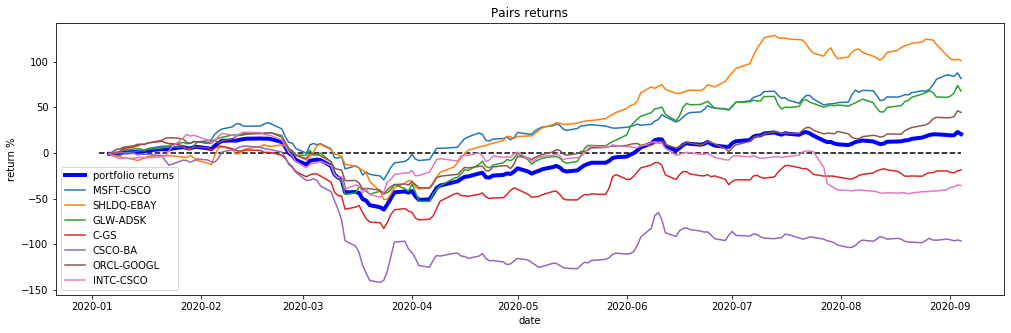

In [128]:
plt.figure(figsize = (17,5))
plt.hlines(0, xmin = raw_returns[0].index.to_timestamp()[0], xmax = raw_returns[0].index.to_timestamp()[-1], color = 'black', linestyles = 'dashed')
plt.plot(raw_returns[0].index.to_timestamp(), (sum(raw_returns)/len(raw_returns)).rolling(2).sum(), label = 'portfolio returns', color = 'blue', linewidth = 4)
for n_ret, ret in enumerate(raw_returns):
    plt.plot(ret.index.to_timestamp(), ret.rolling(2).sum(), label = ret.name)
    plt.legend()
plt.xlabel('date')
plt.ylabel('return %')
plt.title('Pairs returns');

### Backtesting

In [129]:
def view_cum_returns(returns):
    for ret in returns:
        r = ret.rolling(2).sum()[-1:]
        print('cumulative return for {} is {}%'.format(ret.name, r[0]))
    port_ret = sum(returns) / len(returns)
    port_ret_cum = port_ret.rolling(2).sum()[-1:]
    print('cumulative return for portfolio is {}%'.format(port_ret_cum[0]))

In [130]:
view_cum_returns(raw_returns)

cumulative return for MSFT-CSCO is 81.43794225090326%
cumulative return for SHLDQ-EBAY is 101.24780429154977%
cumulative return for GLW-ADSK is 67.7536273608826%
cumulative return for C-GS is -18.658826392974696%
cumulative return for CSCO-BA is -96.38397300057369%
cumulative return for ORCL-GOOGL is 44.32579185400394%
cumulative return for INTC-CSCO is -35.74372830609883%
cumulative return for portfolio is 20.568376865384632%


#### Sharpe ratio

In [131]:
size = len(raw_returns[0])
risk_free = yf.download('^IRX', start = "2020-01-02", end = "2020-09-05")['Adj Close'][-size:]
market_idx = yf.download('^GSPC', start = "2020-01-01", end = "2020-09-05")['Adj Close'].pct_change()[1:][-size:] * 100
risk_free.index = risk_free.index.to_period(freq='d')
market_idx.index = market_idx.index.to_period(freq='d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [132]:
def sharpe(port_returns):
    interest_adj = (1 + risk_free)**(1/252) - 1 #since we are given annual rates
    for p in port_returns:
        excess_return = p - interest_adj
        sharpe = excess_return.mean() / excess_return.std()
        print('Sharpe ratio for {} is {}'.format(p.name, sharpe))
    all_returns = sum(port_returns) / len(port_returns)
    all_ex_ret = all_returns - interest_adj
    sharpe_p = all_ex_ret.mean() / all_ex_ret.std()
    print('Sharpe ratio for portfolio is {}'.format(sharpe_p))

In [133]:
sharpe(raw_returns)

Sharpe ratio for MSFT-CSCO is 1.0478272089798926
Sharpe ratio for SHLDQ-EBAY is 0.7551738962766243
Sharpe ratio for GLW-ADSK is 0.487350938956684
Sharpe ratio for C-GS is -1.192163817693773
Sharpe ratio for CSCO-BA is -1.736879266124932
Sharpe ratio for ORCL-GOOGL is 0.2329928168478736
Sharpe ratio for INTC-CSCO is -0.5032867662125219
Sharpe ratio for portfolio is -0.1586476146167834


#### Beta

In [134]:
from sklearn.linear_model import LinearRegression
def beta(results):
    portfolio_beta = 0
    for i in results:
        capm = LinearRegression(fit_intercept = True).fit(np.array(market_idx).reshape(-1, 1), np.array(i).reshape(-1, 1))
        beta = capm.coef_[0][0]
        print('beta for {} pair is {}'.format(i.name, beta))
        portfolio_beta += beta
    portfolio_beta = portfolio_beta / len(results)
    print('portfolio beta is {}'.format(portfolio_beta))

In [135]:
raw_beta = beta(raw_returns)

beta for MSFT-CSCO pair is -0.22914602135766718
beta for SHLDQ-EBAY pair is 0.06765272956519638
beta for GLW-ADSK pair is -0.2980859806954878
beta for C-GS pair is -0.5581619198893634
beta for CSCO-BA pair is -1.0943225516794377
beta for ORCL-GOOGL pair is -0.3842495861069729
beta for INTC-CSCO pair is -0.38534103193492225
portfolio beta is -0.4116649088712364


#### Maximum drawdown

In [136]:
def max_drawdown(val, allocated_capital):
    max_ = max(val)
    max_idx = list(val).index(max_)
    if max_idx != len(val) -1:
        min_ = min(val[max_idx + 1:])
    else:
        min_ = min(val)
    return (max_ - min_) * 100 / allocated_capital

In [137]:
def daily_drawdown(port_value, allocated_capital):
    sep_drawdowns = []
    for port in port_value:
        day_drawdown = port.diff().dropna()
        day_drawdown = day_drawdown * 100 / allocated_capital
        sep_drawdowns.append(day_drawdown)
        print('maximum daily drawdown for {} is {}%'.format(day_drawdown.name, round(max(day_drawdown), 2)))
    portfolio_drawdown = sum(port_value).diff().dropna() * 100 / (allocated_capital * len(port_value))
    print('maximum daily drawdown for portfolio is {}%'.format(round(max(portfolio_drawdown), 2)))
    return sep_drawdowns, portfolio_drawdown

def week_mdd(port, allocated_capital):
    weeks = port.resample('W')
    week_mdd = []
    for w in weeks:
        w_mdd = max_drawdown(w[1], allocated_capital)
        week_mdd.append(w_mdd)
    return max(week_mdd)


def weekly_drawdown(port_value, allocated_capital):
    sep_drawdowns = []
    for port in port_value:
        w_mdd = week_mdd(port, allocated_capital)
        sep_drawdowns.append(w_mdd)
        print('maximum weekly drawdown for {} is {}%'.format(port.name, round(w_mdd, 2)))
    all_port = sum(port_value)
    portfolio_drawdown  = week_mdd(all_port, allocated_capital * len(port_value))
    print('maximum weekly drawdown for portfolio is {}%'.format(round(portfolio_drawdown, 2)))
    return sep_drawdowns, portfolio_drawdown

In [138]:
raw_day_mdd_sep, raw_day_mdd_all = daily_drawdown(raw_port_value, allocated_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
raw_week_mdd_sep, raw_week_mdd_all = weekly_drawdown(raw_port_value, allocated_capital)

maximum daily drawdown for MSFT-CSCO is 12.33%
maximum daily drawdown for SHLDQ-EBAY is 8.31%
maximum daily drawdown for GLW-ADSK is 11.72%
maximum daily drawdown for C-GS is 11.36%
maximum daily drawdown for CSCO-BA is 9.36%
maximum daily drawdown for ORCL-GOOGL is 8.0%
maximum daily drawdown for INTC-CSCO is 14.67%
maximum daily drawdown for portfolio is 9.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
maximum weekly drawdown for MSFT-CSCO is 14.6%
maximum weekly drawdown for SHLDQ-EBAY is 13.48%
maximum weekly drawdown for GLW-ADSK is 19.9%
maximum weekly drawdown for C-GS is 18.09%
maximum weekly drawdown for CSCO-BA is 32.4%
maximum weekly drawdown for ORCL-GOOGL is 13.45%
maximum weekly drawdown for INTC-CSCO is 16.88%
maximum weekly drawdown for portfolio is 17.72%


#### Accumulated return to maximum drawdown

In [139]:
def return_to_drawdown(port_value, port_returns, allocated_capital):
    for num, port in enumerate(port_value):
        mdd = max_drawdown(port, allocated_capital)
        cum_ret = port_returns[num].rolling(2).sum()[-1:]
        print('accumulated return to maximum drawdown for {} is {}'.format(port.name, round((cum_ret / mdd)[0],2)))

    port_mdd = max_drawdown(sum(raw_port_value), allocated_capital * len(port_value))
    port_returns = sum(port_returns) / len(port_returns)
    port_cum_ret = port_returns.rolling(2).sum()[-1:] 
    print('accumulated return to maximum drawdown for portfolio is {}'.format(round((port_cum_ret / port_mdd)[0],2)))

In [140]:
return_to_drawdown(raw_port_value, raw_returns, allocated_capital)

accumulated return to maximum drawdown for MSFT-CSCO is 9.05
accumulated return to maximum drawdown for SHLDQ-EBAY is 6.13
accumulated return to maximum drawdown for GLW-ADSK is 6.61
accumulated return to maximum drawdown for C-GS is -0.38
accumulated return to maximum drawdown for CSCO-BA is -1.28
accumulated return to maximum drawdown for ORCL-GOOGL is 6.91
accumulated return to maximum drawdown for INTC-CSCO is -0.92
accumulated return to maximum drawdown for portfolio is 3.9


#### 1-day VaR and Expected Shortfall

In [353]:
#Excess distribution over threshold
#Following https://core.ac.uk/download/pdf/81929493.pdf
import scipy.stats as ss
from copulas.multivariate import VineCopula

def VaR(raw_returns, q, alpha, mode = 'none'):

    df = 8 #since there are 8 parameters
    arr = np.full((len(raw_returns[0]) - 1,len(raw_returns)), None)
    pareto_params_l = []
    stud_params = []
    pareto_params_r = []
    means = []
    variances = []
    for nn, rr in enumerate(raw_returns):
        model = arma_garch(rr)
        port_ret = np.array(model[0], dtype = 'float64')
        means.append(model[2])
        variances.append(model[1])
        #left tail
        
        threshold = np.quantile(port_ret, q)
        low_returns = port_ret[port_ret <= threshold]
        pareto = ss.genpareto.fit(-low_returns) #since distribution is defined for right tail only
        pareto_params_l.append(pareto)
        cdf = ss.genpareto.cdf(-low_returns, *pareto)
        arr[:len(cdf), nn] = cdf
        
        #interior - positive and negative
        threshold_r = np.quantile(port_ret, 1 - q) # right tail
        returns_c = port_ret[(threshold < port_ret) & (port_ret < threshold_r)]            
        student = ss.t.fit(returns_c)
        stud_params.append(student)
        cdf_s = ss.t.cdf(returns_c, *student)
        arr[len(cdf):len(cdf)+len(cdf_s), nn] = cdf_s
        
        
        #right tail - positive
       
        high_returns = port_ret[port_ret >= threshold_r]
        pareto_r = ss.genpareto.fit(high_returns) #since distribution is defined for right tail only
        pareto_params_r.append(pareto_r)
        cdf_r = ss.genpareto.cdf(high_returns, *pareto_r)
        arr[len(cdf)+len(cdf_s):, nn] = cdf_r
        
    arr = np.nan_to_num(arr)    
    var_data = pd.DataFrame(arr, dtype = 'float64')
    #var_data = var_data.dropna(axis = 0, how = 'all')

    copula = VineCopula('direct')
    copula.fit(var_data)
    copula_samples = copula.sample(3000)                                                                                        
    var_returns = np.full(copula_samples.shape, 0, dtype = 'float64')
    
    for c in range(copula_samples.shape[1]):
        
        low_l = copula_samples.iloc[:, c].quantile(q)       
        high_l = copula_samples.iloc[:, c].quantile(1 - q)   
        
        #left tail                                                                                     
        params_l = pareto_params_l[c]
        set_l =  copula_samples.iloc[:, c][copula_samples.iloc[:, c] <= low_l]                                                                                   
        inv_l = ss.genpareto.ppf(set_l, *params_l) # return to standartized residuals
        ret_est_l = inv_l * np.sqrt(variances[c]) * (df - 2) / df + means[c]  #since residuals are from Students distribution
        var_returns[:len(ret_est_l), c] = -ret_est_l #because we passed them as positive previously
        
        #interior
        params_c = stud_params[c]
        set_c =  copula_samples.iloc[:, c][(low_l < copula_samples.iloc[:, c]) & (copula_samples.iloc[:, c]< high_l)]                                                                                      
        inv_c = ss.t.ppf(set_c, *params_c) 
        ret_est_c = inv_c * np.sqrt(variances[c]) * (df - 2) / df + means[c] 
        var_returns[len(ret_est_l):len(ret_est_l)+len(ret_est_c), c] = ret_est_c   
        
        #right tail
        params_r = pareto_params_r[c]
        set_h =  copula_samples.iloc[:, c][copula_samples.iloc[:, c] >= high_l]                                                                                      
        inv_r = ss.genpareto.ppf(set_h, *params_r) 
        ret_est_r = inv_r * np.sqrt(variances[c])*(df - 2) / df + means[c]
        var_returns[len(ret_est_l)+len(ret_est_c):, c] = ret_est_r                                                                                        
                                                                                             
                                                                                             
    var_returns = np.nan_to_num(var_returns)
    var_port_ret = np.sum(var_returns, axis = 1) / var_returns.shape[1]
    var = np.quantile(var_port_ret, alpha)
    if mode != 'rachev':
        print('VaR at {}% level is {}%'.format(alpha, round(var, 2)))
    return var, var_port_ret

def ES(var, var_port_ret, mode = 'none'):
    shortfall = var_port_ret[var_port_ret < var].mean()
    if mode != 'rachev':
        print('Expected shortfall is {}%'.format(round(shortfall, 2)))
    return shortfall

In [354]:
raw_var, raw_var_ret = VaR(raw_returns, 0.1, 0.05)
raw_es = ES(raw_var, raw_var_ret)

VaR at 0.05% level is -3.81%
Expected shortfall is -5.01%


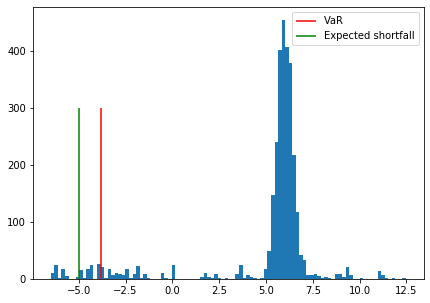

In [355]:
plt.figure(figsize=(7,5))
plt.vlines(raw_var, 0, 300, color = 'red', label = 'VaR')
plt.vlines(raw_es, 0, 300, color = 'green', label = 'Expected shortfall')
plt.hist(raw_var_ret, bins = 100)
plt.legend();

#### Rachev Ratio

In [350]:
def rachev_ratio(raw_returns):
    var_l, returns_l = VaR(raw_returns, 0.1, 0.01, mode = 'rachev') # left tail
    es_den = ES(var_l, returns_l, mode = 'rachev')
    
    reversed_returns = [] # reverse distribution
    for r in raw_returns:
        reversed_returns.append(-r)
    
    var_r, returns_r = VaR(reversed_returns, 0.1, 0.05, mode = 'rachev') # right tail
    es_num = -ES(var_r, returns_r, mode = 'rachev')

    print('Rachev ratio is {}'.format( - round(es_num / es_den, 2)))

In [351]:
rachev_ratio(raw_returns)

Rachev ratio is 9.35
